# ARIMA Forecasting Model

After establishing a baseline with our naive model, we now move on to a more sophisticated classical time series model: **ARIMA (AutoRegressive Integrated Moving Average)**. ARIMA models are a powerful class of models that can capture complex temporal structures in the data.

**The key steps in this notebook are:**
* **Data Preparation:** We'll load our prepared data and split it into training and testing sets.
* **Stationarity Check:** We will check if our time series is stationary, a key requirement for ARIMA models, and apply differencing if necessary.
* **Model Identification:** We will use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to determine the appropriate parameters for our ARIMA model.
* **Model Fitting and Evaluation:** We will fit the ARIMA model to our training data and evaluate its performance on the test data using R-squared and MAPE.
* **Forecasting and Visualization:** Finally, we will use our trained model to make forecasts and visualize the results.

### Import libraries and data prep

We begin by importing the necessary libraries for our analysis and loading the prepared time series data. As in the previous notebook, we will work with the first three months of 2014 to ensure a manageable dataset size for faster modelling.

In [1]:
#Data analysis
import pandas as pd

#Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

#Formatting
sns.set_style("whitegrid")
sns.color_palette("coolwarm")
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

#Modelling and evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [5]:
#Loading data
df_ts = pd.read_parquet("/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/data/df_ts_checkpoint4.parquet")

In [6]:
df_ts.shape

(9437752, 14)

In [7]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9437752 entries, 2013-01-02 to 2014-03-31
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   store_nbr          int64  
 1   item_nbr           int64  
 2   unit_sales         float64
 3   onpromotion        float64
 4   unit_sales_log     float64
 5   is_outlier         bool   
 6   year               int64  
 7   month              int64  
 8   day                int64  
 9   day_of_week        int64  
 10  unit_sales_7d_avg  float64
 11  is_holiday         int64  
 12  dcoilwtico         float64
 13  family             object 
dtypes: bool(1), float64(5), int64(7), object(1)
memory usage: 1017.1+ MB


In [8]:
df_ts.tail()

,store_nbr,item_nbr,unit_sales,onpromotion,unit_sales_log,is_outlier,year,month,day,day_of_week,unit_sales_7d_avg,is_holiday,dcoilwtico,family
date,,,,,,,,,,,,,,
2014-03-27,51,2123791,1.0,NaN,0.693147,False,2014,3,27,3,1.0,0,101.25,GROCERY I
2014-03-28,51,2123791,1.0,NaN,0.693147,False,2014,3,28,4,1.0,0,101.73,GROCERY I
2014-03-29,51,2123791,1.0,NaN,0.693147,False,2014,3,29,5,1.0,0,101.73,GROCERY I
2014-03-30,51,2123791,1.0,NaN,0.693147,False,2014,3,30,6,1.0,0,101.73,GROCERY I
2014-03-31,51,2123791,1.0,NaN,0.693147,False,2014,3,31,0,1.0,0,101.57,GROCERY I


### Time series EDA

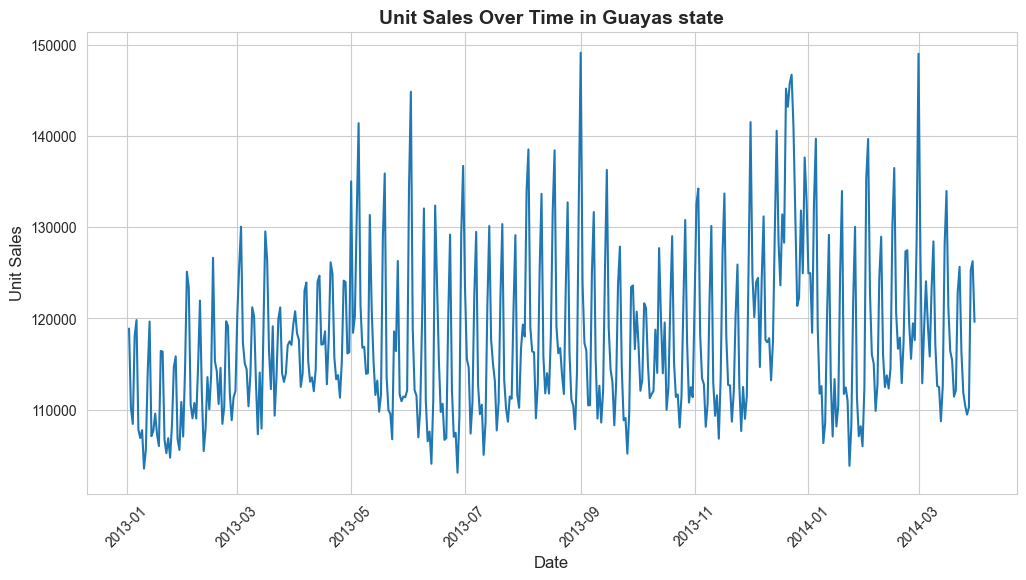

In [10]:
#Aggregate unit sales by day
df_daily_sales = df_ts.groupby(df_ts.index).agg({"unit_sales": "sum"})

#Plotting the time-series, first with unit sales
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales.index, df_daily_sales["unit_sales"])
plt.title('Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [11]:
#Converting to a Pandas Series for modelling
ts_am = df_daily_sales["unit_sales"]

A key assumption of ARIMA models is that the time series is **stationary**. A stationary time series is one whose statistical properties (such as mean and variance) do not change over time. We will use the **Augmented Dickey-Fuller (ADF) test** to check for stationarity.

The null hypothesis of the ADF test is that the time series is non-stationary. If the p-value of the test is less than a significance level (e.g. 0.05), we can reject the null hypothesis and conclude that the time series is stationary.

<Figure size 800x500 with 0 Axes>

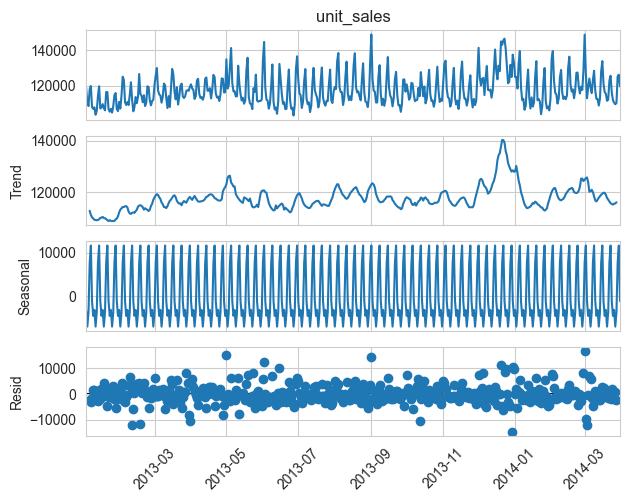

In [12]:
#Checking components of the time series
seasonal = seasonal_decompose(ts_am)

#plotting results
plt.figure(figsize=(8, 5))
seasonal.plot()
plt.xticks(rotation=45)
plt.show()

In [13]:
#Checking if the time series is stationary and fit for modelling
adf_result = adfuller(ts_am)
p_value = adf_result[1]
if p_value < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")

The series is stationary (reject H0).


<Figure size 1600x800 with 0 Axes>

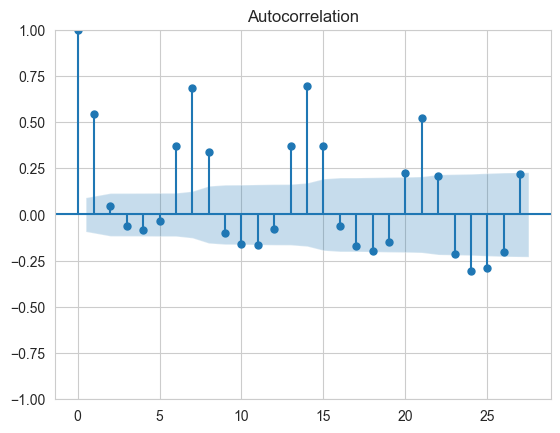

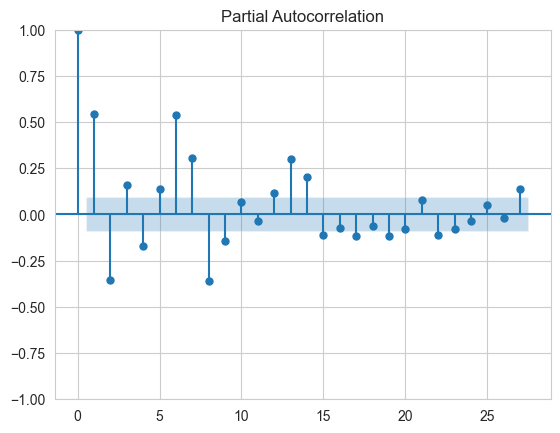

In [14]:
#Checking seasonality dependencies using acf and pacf
plt.figure(figsize=(16,8))
plot_acf(ts_am)
plot_pacf(ts_am)
plt.show()

Even though the ADF test recorded the time series as stationary, there are clear spikes and seasonality. I will now revert to the unit_sales_log feature and apply differencing before modelling.

### Transforming data

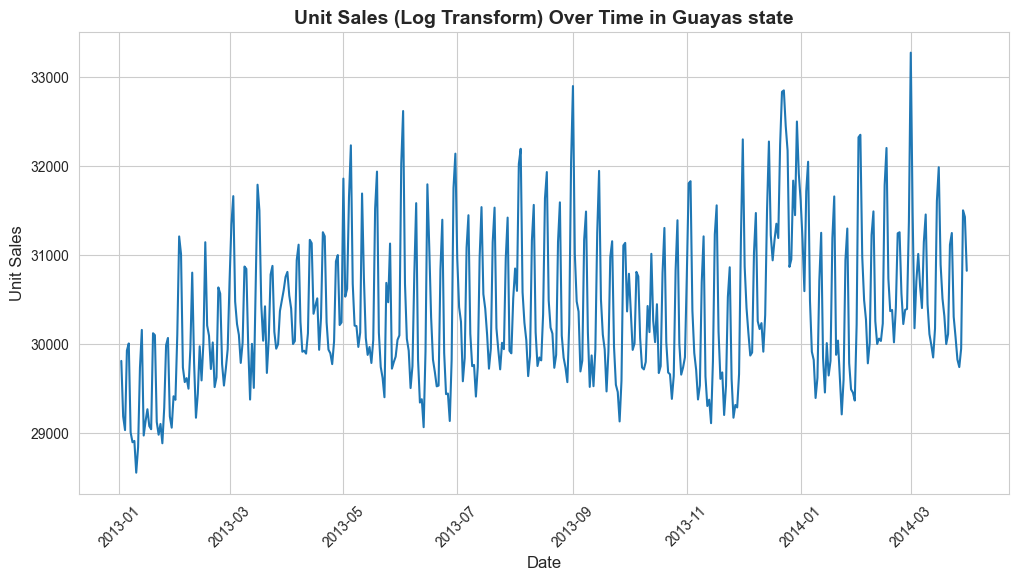

In [15]:
#Aggregate unit_sales_log by day
df_daily_sales_log = df_ts.groupby(df_ts.index).agg({"unit_sales_log": "sum"})

#Plotting the timeseries for inspection
plt.figure(figsize=(12,6))
plt.plot(df_daily_sales_log.index, df_daily_sales_log["unit_sales_log"])
plt.title('Unit Sales (Log Transform) Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unit Sales', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

In [16]:
#Converting to Series
ts_am_log = df_daily_sales_log.squeeze().asfreq('D')

In [17]:
#Sorting ts
ts_am_log = ts_am_log.sort_index()

<Figure size 800x500 with 0 Axes>

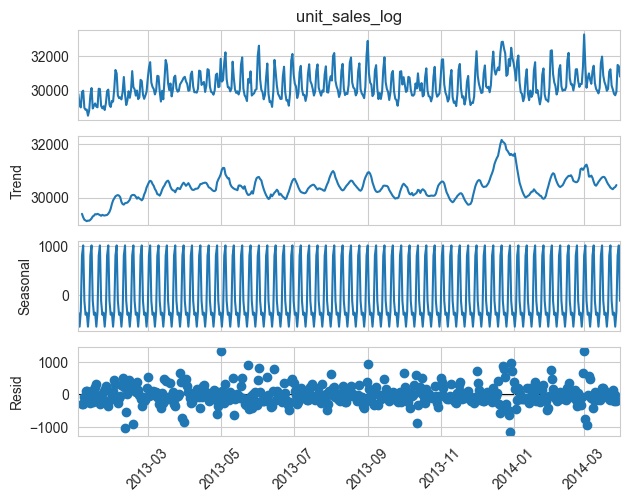

In [18]:
#Checking components of the time series
seasonal_diff = seasonal_decompose(ts_am_log)

#plotting results
plt.figure(figsize=(8, 5))
seasonal_diff.plot()
plt.xticks(rotation=45)
plt.show()

<Figure size 1600x800 with 0 Axes>

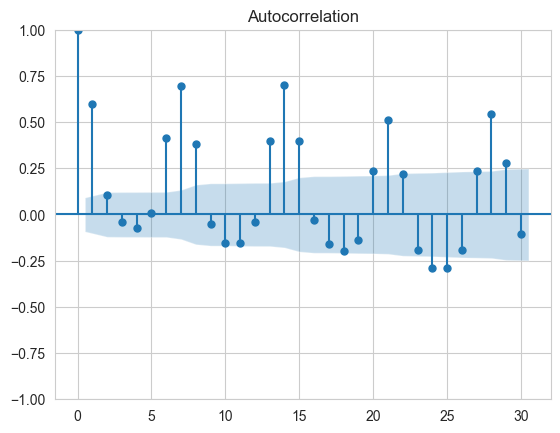

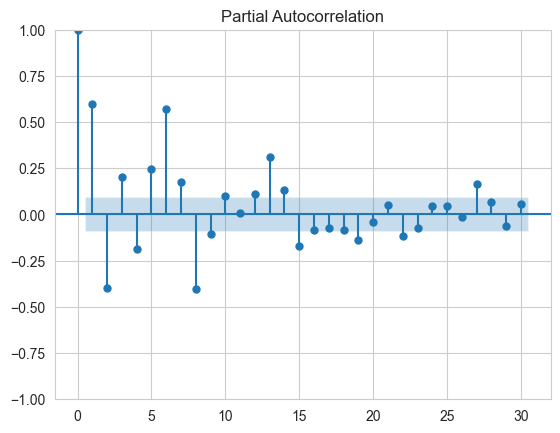

In [19]:
#Checking seasonality dependencies using acf and pacf
plt.figure(figsize=(16,8))
plot_acf(ts_am_log, lags=30)
plot_pacf(ts_am_log, lags=30)
plt.show()

In [20]:
#Checking if the time series is stationary and fit for modelling
adf_result = adfuller(ts_am_log)
p_value = adf_result[1]
if p_value < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")

The series is stationary (reject H0).


### ARIMA

Now that we have a stationary time series, we need to determine the parameters (p, d, q) for our ARIMA model.

* **p (AR order):** The number of lag observations included in the model. We can estimate this from the **Partial Autocorrelation (PACF) plot.**
* **d (differencing order):** The number of times the raw observations are differenced. We have already determined this to be **1**.
* **q (MA order):** The size of the moving average window. We can estimate this from the **Autocorrelation (ACF) plot.**

We will now plot the ACF and PACF of our stationary (differenced) series to determine the appropriate values for p and q.

We will use the same training/testing split as in our naive model notebook: data before March 1st, 2014, for training, and data from March 1st onwards for testing. This consistency is crucial for comparing the performance of our different models.

In [21]:
#Defining the split date based on forecast target
split_date = "2014-01-01"

# Create training and testing sets
train = ts_am_log[:split_date]
test = ts_am_log[split_date:"2014-03-31"]

Based on the ACF and PACF plots, we will start with an ARIMA(1, 1, 2) model and then experiment with other orders to find the best fit.

In [22]:
arima_model = ARIMA(train, order=(1, 1, 2))
arima_fit = arima_model.fit()

/Users/dan/PycharmProjects/Masterschool/TimeSeriesRetailForecast/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [23]:
arima_forecast = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

<Axes: xlabel='date'>

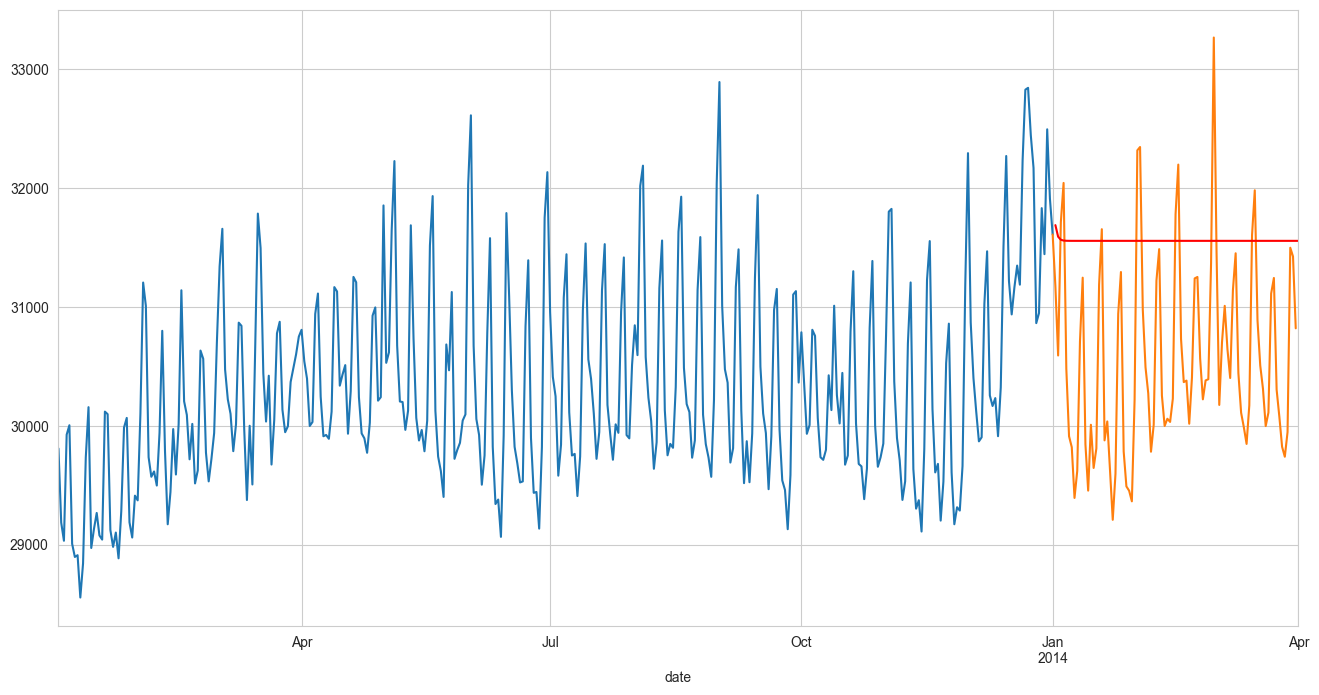

In [24]:
plt.figure(figsize=(16,8))
train.plot(label="Train", color="#ff7f0e")
test.plot(label="Test", color ="#1f77b4")
arima_forecast.plot(label="Forecast", color="red")

In [25]:
r2 = r2_score(test, arima_forecast)
mape = mean_absolute_percentage_error(test, arima_forecast)

print(f"ARIMA R2 Score: {r2:.4f}")
print(f"ARIMA MAPE: {mape * 100:.2f}%")

ARMA R2 Score: -1.4802
ARIMA MAPE: 3.65%


In [26]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unit_sales_log   No. Observations:                  365
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2861.790
Date:                Fri, 09 May 2025   AIC                           5731.580
Time:                        07:56:15   BIC                           5747.168
Sample:                    01-02-2013   HQIC                          5737.776
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2639      0.056      4.749      0.000       0.155       0.373
ma.L1         -0.3853      0.043     -8.895      0.000      -0.470      -0.300
ma.L2         -0.4775      0.024    -19.508      0.000      -0.526      -0.430
sigma2       3.31e+05   2.39e+04     13.844      0.000    2.84e+05    3.78e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                21.82
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.54
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The visualization shows that our ARIMA model does a much better job of capturing the underlying trend in the data compared to the naive model. The R-squared value is improving, and the MAPE has decreased significantly.

However, the model still struggles to capture the daily volatility and sharp spikes in sales. This suggests that while the ARIMA model is an improvement, it may not be enough to capture all the complexities of our sales data.

After testing different order = values according to acf and pacf the model above delivers the best results according to r2 and MAPE evaluation metrics. Whilst the forecast is close in % terms, the model is not capturing the variance.

This leads us to our final model, where we will explore a more powerful machine learning approach: XGBoost.